In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import json

In [2]:
from matplotlib import rc
rc('font', family='sans-serif')
rc('font', size=13.0)
rc('text', usetex=False)
# rc('figure', figsize=(11.69,8.27))

from matplotlib.font_manager import FontProperties

panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(14.0)
panel_label_font.set_family("sans-serif")

# Pandas options
pd.options.display.float_format = '{:,.2f}'.format

# Seaborn styles
sns.set_style("whitegrid")

In [3]:
data_dir = "/home/asura/Dropbox/Shared/Juan/paperbuzz/paperbuzz_metrics.csv"
articles = pd.read_csv(data_dir, na_values=0)

articles.set_index("id", inplace=True)
articles['date'] = pd.to_datetime(articles['date'], errors = 'coerce')

# Drop rows without date
articles = articles[~articles.date.isnull()]

# Extract doi prefixes
articles['doi_prefix'] = articles.doi.map(lambda x: x[:x.find('/')])

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Aggregate articles by DOI prefixes
def coverage(x): 
    return len(x[x>0]) / len(x)

# Compute counts, means and coverage for doi prefixes
prefixes = pd.DataFrame(articles[articles.date.between('2017-01-01', '2017-12-31')] \
                    .groupby('doi_prefix').agg(['count', 'mean', coverage]))

# Keep only those that have at least 5 articles in 2017
prefixes = prefixes[prefixes['n_authors']['count'] >= 5]

In [5]:
articles[['twitter', 'wikipedia', 'crossref', 'hypothesis']].describe()

,twitter,wikipedia,crossref,hypothesis
count,"14,794.00","6,681.00","1,929.00",3.00
mean,4.47,15.35,3.50,11.33
std,12.64,44.67,7.41,14.57
min,1.00,1.00,1.00,1.00
25%,1.00,2.00,1.00,3.00
50%,2.00,4.00,1.00,5.00
75%,4.00,12.00,3.00,16.50
max,607.00,"1,263.00",151.00,28.00


In [6]:
prefixes[['twitter', 'wikipedia', 'crossref', 'hypothesis']].describe()

twitter                 wikipedia                 crossref       \
         count   mean coverage     count   mean coverage    count mean   
count 1,145.00 395.00 1,145.00  1,145.00 217.00 1,145.00 1,145.00 9.00   
mean      3.82   3.63     0.04      0.52  16.63     0.00     0.05 1.05   
std      16.72   7.78     0.11      2.32  46.06     0.03     1.12 0.12   
min       0.00   1.00     0.00      0.00   1.00     0.00     0.00 1.00   
25%       0.00   1.00     0.00      0.00   2.33     0.00     0.00 1.00   
50%       0.00   2.00     0.00      0.00   5.67     0.00     0.00 1.00   
75%       1.00   3.66     0.02      0.00  12.27     0.00     0.00 1.00   
max     295.00 123.20     1.00     38.00 545.00     0.82    37.00 1.32   

               hypothesis                
      coverage      count mean coverage  
count 1,145.00   1,145.00 0.00 1,145.00  
mean      0.00       0.00  nan     0.00  
std       0.02       0.00  nan     0.00  
min       0.00       0.00  nan     0.00  
25%       0.00       0.00  nan     0.00  
50%       0.00       0.00  nan     0.00  
75%       0.00       0.00  nan     0.00  
max       0.60       0.00  nan     0.00

## Coverage numbers for individual articles/journals

In [60]:
df = pd.DataFrame(columns=[])
df = (100*articles.describe().loc['count']
        .div(len(articles)).sort_values(ascending=False)
        .to_frame("Articles"))
df['Journals'] = (100*prefixes.replace(0, np.nan).describe().loc['count']
                        .xs('count', level=1).sort_values(ascending=False)
                        .to_frame().div(len(prefixes)))
df = df.drop("n_authors")
(df.round(2).sort_values(by="Journals", ascending=False)
     .style.set_caption("Coverage for articles and DOI prefixes").background_gradient(axis=None, cmap="Greens"))

,Articles,Journals
twitter,1.33,34.5
wikipedia,0.6,18.95
wordpressdotcom,0.04,4.89
datacite,0.06,2.18
newsfeed,0.01,1.66
reddit-links,0.01,1.22
crossref,0.17,0.79
reddit,0.01,0.44
f1000,0,0.44
cambia-lens,0.06,0.17


## Coverage vs means for journals

In [61]:
plot_metrics = ["twitter", "wikipedia", "wordpressdotcom", "datacite", "newsfeed", "reddit-links"]

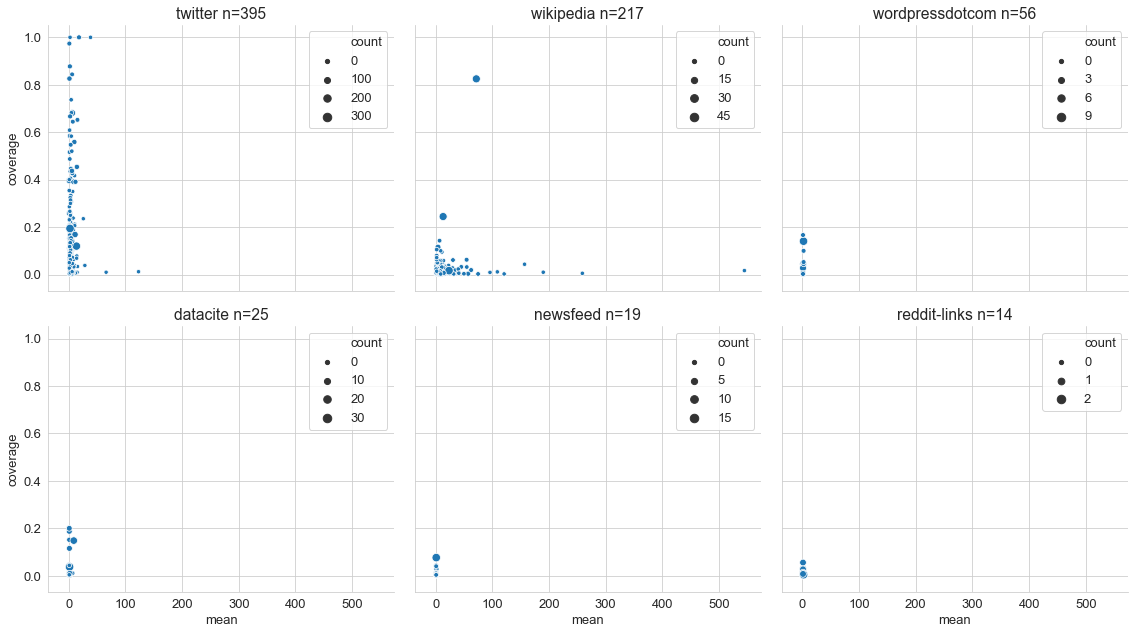

In [62]:
fig, axes = plt.subplots(2,3, figsize=(16, 9), sharey=True, sharex=True)

for metric, ax in zip(plot_metrics, axes.flatten()):
    sns.scatterplot(x='mean', y='coverage', size='count', data=prefixes[metric], ax=ax)
    ax.set_title("{} n={}".format(metric, sum(prefixes[metric]['count']!=0)))
    sns.despine(top=True, right=True, ax=ax)
plt.tight_layout()
plt.savefig('figures/coverages.png')

## Correlations (journals)

In [58]:
(prefixes.drop(["stackexchange", "hypothesis"], axis=1).xs("count", axis=1, level=1).corr(method="spearman")
     .sort_values("twitter", ascending=False)
     .sort_values("twitter", ascending=False, axis=1)
     .style
     .background_gradient(axis=None, cmap="Greens")
     .format("{:.2f}")
     .set_caption("Spearman correlation ")

,twitter,wikipedia,n_authors,wordpressdotcom,newsfeed,reddit-links,datacite,crossref,reddit,cambia-lens,web,f1000
twitter,1.00,0.40,0.36,0.32,0.19,0.13,0.11,0.08,0.08,0.06,0.05,0.05
wikipedia,0.40,1.00,0.41,0.25,0.17,0.12,0.10,0.07,0.07,0.09,0.06,0.04
n_authors,0.36,0.41,1.00,0.18,0.14,0.09,0.13,0.04,0.08,0.06,0.02,0.06
wordpressdotcom,0.32,0.25,0.18,1.00,0.29,0.20,0.10,0.12,0.11,-0.01,-0.01,0.05
newsfeed,0.19,0.17,0.14,0.29,1.00,0.24,0.17,0.14,0.09,-0.01,-0.00,0.09
reddit-links,0.13,0.12,0.09,0.20,0.24,1.00,0.04,0.08,0.23,-0.00,-0.00,-0.01
datacite,0.11,0.10,0.13,0.10,0.17,0.04,1.00,0.12,0.08,-0.01,0.20,0.08
crossref,0.08,0.07,0.04,0.12,0.14,0.08,0.12,1.00,-0.01,-0.00,-0.00,0.29
reddit,0.08,0.07,0.08,0.11,0.09,0.23,0.08,-0.01,1.00,-0.00,-0.00,-0.00
cambia-lens,0.06,0.09,0.06,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,1.00,-0.00,-0.00


## Countries